In [1]:

# ref https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52

In [2]:
from __future__ import print_function
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib
## This is for backend, gui support, but it doesnt do anything ##
matplotlib.use('TkAgg') 
from matplotlib import figure, pyplot
import math
import nltk
from nltk.corpus import stopwords
from datetime import datetime
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix, lil_matrix
from tqdm.auto import tqdm
from operator import itemgetter
import heapq
import collections
from pathlib import Path

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import seaborn as sns


In [3]:
##### Rename RiskFactors > Data > Run  <for f in *\ *; do mv "$f" "${f// /_}"; done> in bash, in Data ####
##### This changes all " " characters to "_", needed for Path######
##### See https://stackoverflow.com/a/18213120 #####


NUMBER_OF_DOCS = 50
doclist = []
names = []
pathlist = Path("Data_Small").glob('**/*.txt')
pathlist = Path("Data").glob('**/*.txt')
for path in tqdm(pathlist):
    # because path is object not string
    path_in_str = str(path)
    name = path_in_str.split("\\")[1].split(".")[0]
    names.append(name.replace("_", " "))
    #TODO SPLIT PATH TO COMPANY NAME, make Index
    file = open(path, "r") 
    # print "Output of Readlines after appending"
    text = file.readlines()
#     print(text[:10])
    doclist.append(text[0].replace(name, "<NAME>"))
if len(doclist) > NUMBER_OF_DOCS:
    doclist = doclist[:NUMBER_OF_DOCS]
    names = names[:NUMBER_OF_DOCS]

In [4]:
print('%s docs loaded'% len(names))
print()
print(names[:10], '......',  names[-10:])


50 docs loaded

['180 Degree Capital Corp ', '1 800 FLOWERS COM Inc ', '2U Inc ', '3D Systems Corporation', '3M Company', 'A10 Networks Inc ', 'AAC Holdings Inc ', 'AAON Inc ', 'AAR Corp ', 'Abbott Laboratories'] ...... ['Adaptimmune Therapeutics plc', 'Adesto Technologies Corporation', 'Adient plc', 'Adobe Inc ', 'ADOMANI Inc ', 'Adtalem Global Education Inc ', 'ADTRAN Inc ', 'ADT Inc ', 'Aduro Biotech Inc ', 'Advanced Disposal Services Inc ']


In [5]:
# doclist[1]

# len(doclist[0])

In [6]:
punc = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}',"%"]
more_stops = ['\\t\\t\\t', 
    '\\t\\t\\', '\\t\\t\\t',
    '<U+25CF>', '[1]']
maybe_bad_stops = ['may', 'could',  'contents', 'table', 'time', 'risk factors']
stopWordsSet =  stopwords.words('english') + more_stops + punc + maybe_bad_stops

In [7]:
def split_document(document, stopWordsSet):
    split_text = [word.lower() for word in document.replace(
        ";", ".").replace('<u+0095>', ".").split(".") if word not in stopWordsSet]
    return split_text



In [8]:
def big_split(doclist, stopWordsSet):
    big_split_text_list = []
    big_split_name_list = []
    
    for counter, document in tqdm(enumerate(doclist)):
        name = names[counter]
        split_text =  [word.lower() for word in document.replace(
        ";", ".").replace('<u+0095>', ".").replace("  ", "").split(".") if word not in stopWordsSet]
        big_split_name_list += [name for word in document.replace(
        ";", ".").replace('<u+0095>', ".").replace("  ", "").split(".") if word not in stopWordsSet]
        big_split_text_list += split_text
    return big_split_text_list, big_split_name_list, stopWordsSet

In [9]:
def vectorize_text(split_text_entry, longest_paragraph_len):

#     stop_words = text.ENGLISH_STOP_WORDS.union(punc)
    vectorizer = TfidfVectorizer(stop_words=stopWordsSet,
                                 ngram_range=(1,15))
#     vectorizer = CountVectorizer(stop_words=stopWordsSet,
#                                  ngram_range=(1,15))
    sparseMatrix = vectorizer.fit_transform(split_text_entry)
    # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform
    return sparseMatrix, vectorizer  

In [10]:
# split_text = split_document(doclist[0], stopWordsSet)
# sparseMatrix, vectorizer = vectorize_text(split_text)
# longest_paragraph_len = max(split_text, key=len)
# for multiple files, uncomment below
%time big_split_text_list, big_split_name_list, stopWordsSet = big_split(doclist, stopWordsSet)
longest_paragraph_len = len(max(big_split_text_list, key=len))


Wall time: 277 ms


In [11]:
%time sparseMatrix, vectorizer = vectorize_text(big_split_text_list, longest_paragraph_len)
# I dont think we can get tqdm to work here #

C:\Users\xanen\Anaconda3\envs\Tensor\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['25cf', 'factors', 'risk'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 11.9 s


In [12]:
big_split_name_list[:5]

['180 Degree Capital Corp ',
 '180 Degree Capital Corp ',
 '180 Degree Capital Corp ',
 '180 Degree Capital Corp ',
 '180 Degree Capital Corp ']

In [13]:
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 15), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...';', '(', ')', '[', ']', '{', '}', '%', 'may', 'could', 'contents', 'table', 'time', 'risk factors'],
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [14]:
sparseMatrix
# With this, each column in the matrix represents a word in the vocabulary
# each row represents the document in our dataset 
# where the values in this case are the word counts or Doc Freq if we are using tfidf vectorizer

<38212x2461456 sparse matrix of type '<class 'numpy.float64'>'
	with 3302400 stored elements in Compressed Sparse Row format>

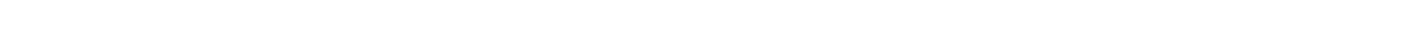

In [52]:
%matplotlib inline

# This doesnt really work when passing many documents > 100?
# https://stackoverflow.com/questions/22961541/python-matplotlib-plot-sparse-matrix-pattern

def plot_coo_matrix(m):
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    fig = pyplot.figure(figsize=(25, 10))
    ax = fig.add_subplot(111, facecolor ='black')
    ax.plot(m.col, m.row, 's', color='white', ms=3)
    ax.set_xlim(0, m.shape[1])
    ax.set_ylim(0, m.shape[0])
    ax.set_aspect('equal')
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.invert_yaxis()
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    return ax

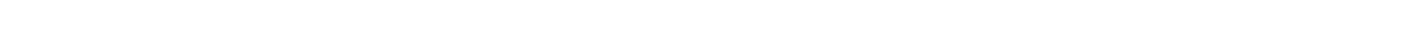

In [55]:
plot_coo_matrix(sparseMatrix).figure.show()


In [16]:
# truek = PLEASE_FIND_ME
def cluster_it(sparseMatrix, vectorizer):
    truek = 35
    model = KMeans(n_clusters=truek, init='k-means++',
                   max_iter=100, n_init=1, random_state=42)
    model.fit(sparseMatrix)
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    return terms, order_centroids, model, truek

In [17]:
##THIS TAKES ~~ 1m per 100 documents
 %time terms, order_centroids, model, truek = cluster_it(sparseMatrix, vectorizer)

Wall time: 25.4 s


In [18]:
# using joblib to pickle model
model_time = datetime.now().strftime("%b%d-%I%M%p")
from sklearn.externals import joblib
joblib.dump(model, f'outputs/s2s{model_time}.pkl')
model = joblib.load(f'outputs/s2s{model_time}.pkl')

In [19]:
clusters = model.labels_.tolist()
clusters

[4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 25,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,

In [20]:
def dataframe_it(big_split_text_list, big_split_name_list, clusters):
    first_we_dict = {'company': big_split_name_list, 'split': big_split_text_list, 'cluster': clusters}
    frame = pd.DataFrame(first_we_dict, index =clusters, columns = ['cluster', 'company', 'split'])   
    return frame

In [21]:
all_doc_df = dataframe_it(big_split_text_list, big_split_name_list, clusters)

In [22]:
all_doc_df.head()

cluster                   company  \
4        4  180 Degree Capital Corp    
4        4  180 Degree Capital Corp    
4        4  180 Degree Capital Corp    
4        4  180 Degree Capital Corp    
4        4  180 Degree Capital Corp    

                                               split  
4                                       [1] "item 1a  
4                                       risk factors  
4                                                     
4   investing in our common stock involves signif...  
4   you should carefully consider the risks and u...

In [23]:
all_doc_df['company'] = all_doc_df['company'].str.replace("_", " ")
all_doc_df.head()

cluster                   company  \
4        4  180 Degree Capital Corp    
4        4  180 Degree Capital Corp    
4        4  180 Degree Capital Corp    
4        4  180 Degree Capital Corp    
4        4  180 Degree Capital Corp    

                                               split  
4                                       [1] "item 1a  
4                                       risk factors  
4                                                     
4   investing in our common stock involves signif...  
4   you should carefully consider the risks and u...

In [24]:
terms[:15]

['00',
 '00 42',
 '00 case',
 '00 case abr',
 '00 case abr loans',
 '00 case eurodollar',
 '00 case eurodollar loans',
 '00 case eurodollar loans september',
 '00 case eurodollar loans september 2018',
 '00 case eurodollar loans september 2018 amendment',
 '00 case eurodollar loans september 2018 amendment limitation',
 '00 case eurodollar loans september 2018 amendment limitation period',
 '00 case eurodollar loans september 2018 amendment limitation period requiring',
 '00 case eurodollar loans september 2018 amendment limitation period requiring company',
 '00 case eurodollar loans september 2018 amendment limitation period requiring company maintain']

In [25]:
nclosest_words_to_show = 5
for i in range(truek):
 print('Cluster %d:' % i),
 for ind in order_centroids[i, :nclosest_words_to_show]:
     print(' %s' % terms[ind])

Cluster 0:
 revenue derived sales outside americas region 64 2018 60
 outside americas region 64
 outside americas region 64 2018 60
 outside americas region 64 2018 60 2016
 outside americas region 64 2018 60 2016 2017
Cluster 1:
 common stock march 15
 stock march 15 2018
 common stock march 15 2018
 march 15 2018
 march 15
Cluster 2:
 valuable asset
 property portfolio valuable asset
 property portfolio valuable
 portfolio valuable asset
 portfolio valuable
Cluster 3:
 following discussion risk factors contains forward looking
 following discussion risk factors
 factors contains forward
 factors contains
 factors contains forward looking statements
Cluster 4:
 feff
 business
 products
 product
 operations
Cluster 5:
 risks related intellectual property
 risks related intellectual
 related intellectual property
 related intellectual
 risks related
Cluster 6:
 face substantial competition competitors discover develop commercialize products faster successfully
 commercialize products f

In [26]:
print('\n')
print('Prediction')
X = vectorizer.transform(['The hackers stole all our bitcoin!'])
predicted = model.predict(X)
print(predicted)





Prediction
[4]


In [27]:
# HOW DO WE FIND the tag label?, 1Closest_word to cluster definitely isn't it
for i in range(truek):
 print('Cluster %d:' % i),
 for ind in order_centroids[i, :1]:
     print(' %s' % terms[ind])

Cluster 0:
 revenue derived sales outside americas region 64 2018 60
Cluster 1:
 common stock march 15
Cluster 2:
 valuable asset
Cluster 3:
 following discussion risk factors contains forward looking
Cluster 4:
 feff
Cluster 5:
 risks related intellectual property
Cluster 6:
 face substantial competition competitors discover develop commercialize products faster successfully
Cluster 7:
 us agreements third parties cannot control whether
Cluster 8:
 55
Cluster 9:
 cannot certain future compliance
Cluster 10:
 party payor
Cluster 11:
 addition ultimately unable reduce expenses associated spear cells levels allow us achieve
Cluster 12:
 sale support products also entail risk product liability claims
Cluster 13:
 foreign currency exchange rate fluctuations materially impact consolidated financial position results operations
Cluster 14:
 approximately
Cluster 15:
 facility determined
Cluster 16:
 patient
Cluster 17:
 37
Cluster 18:
 company
Cluster 19:
 29
Cluster 20:
 healthcare reform re

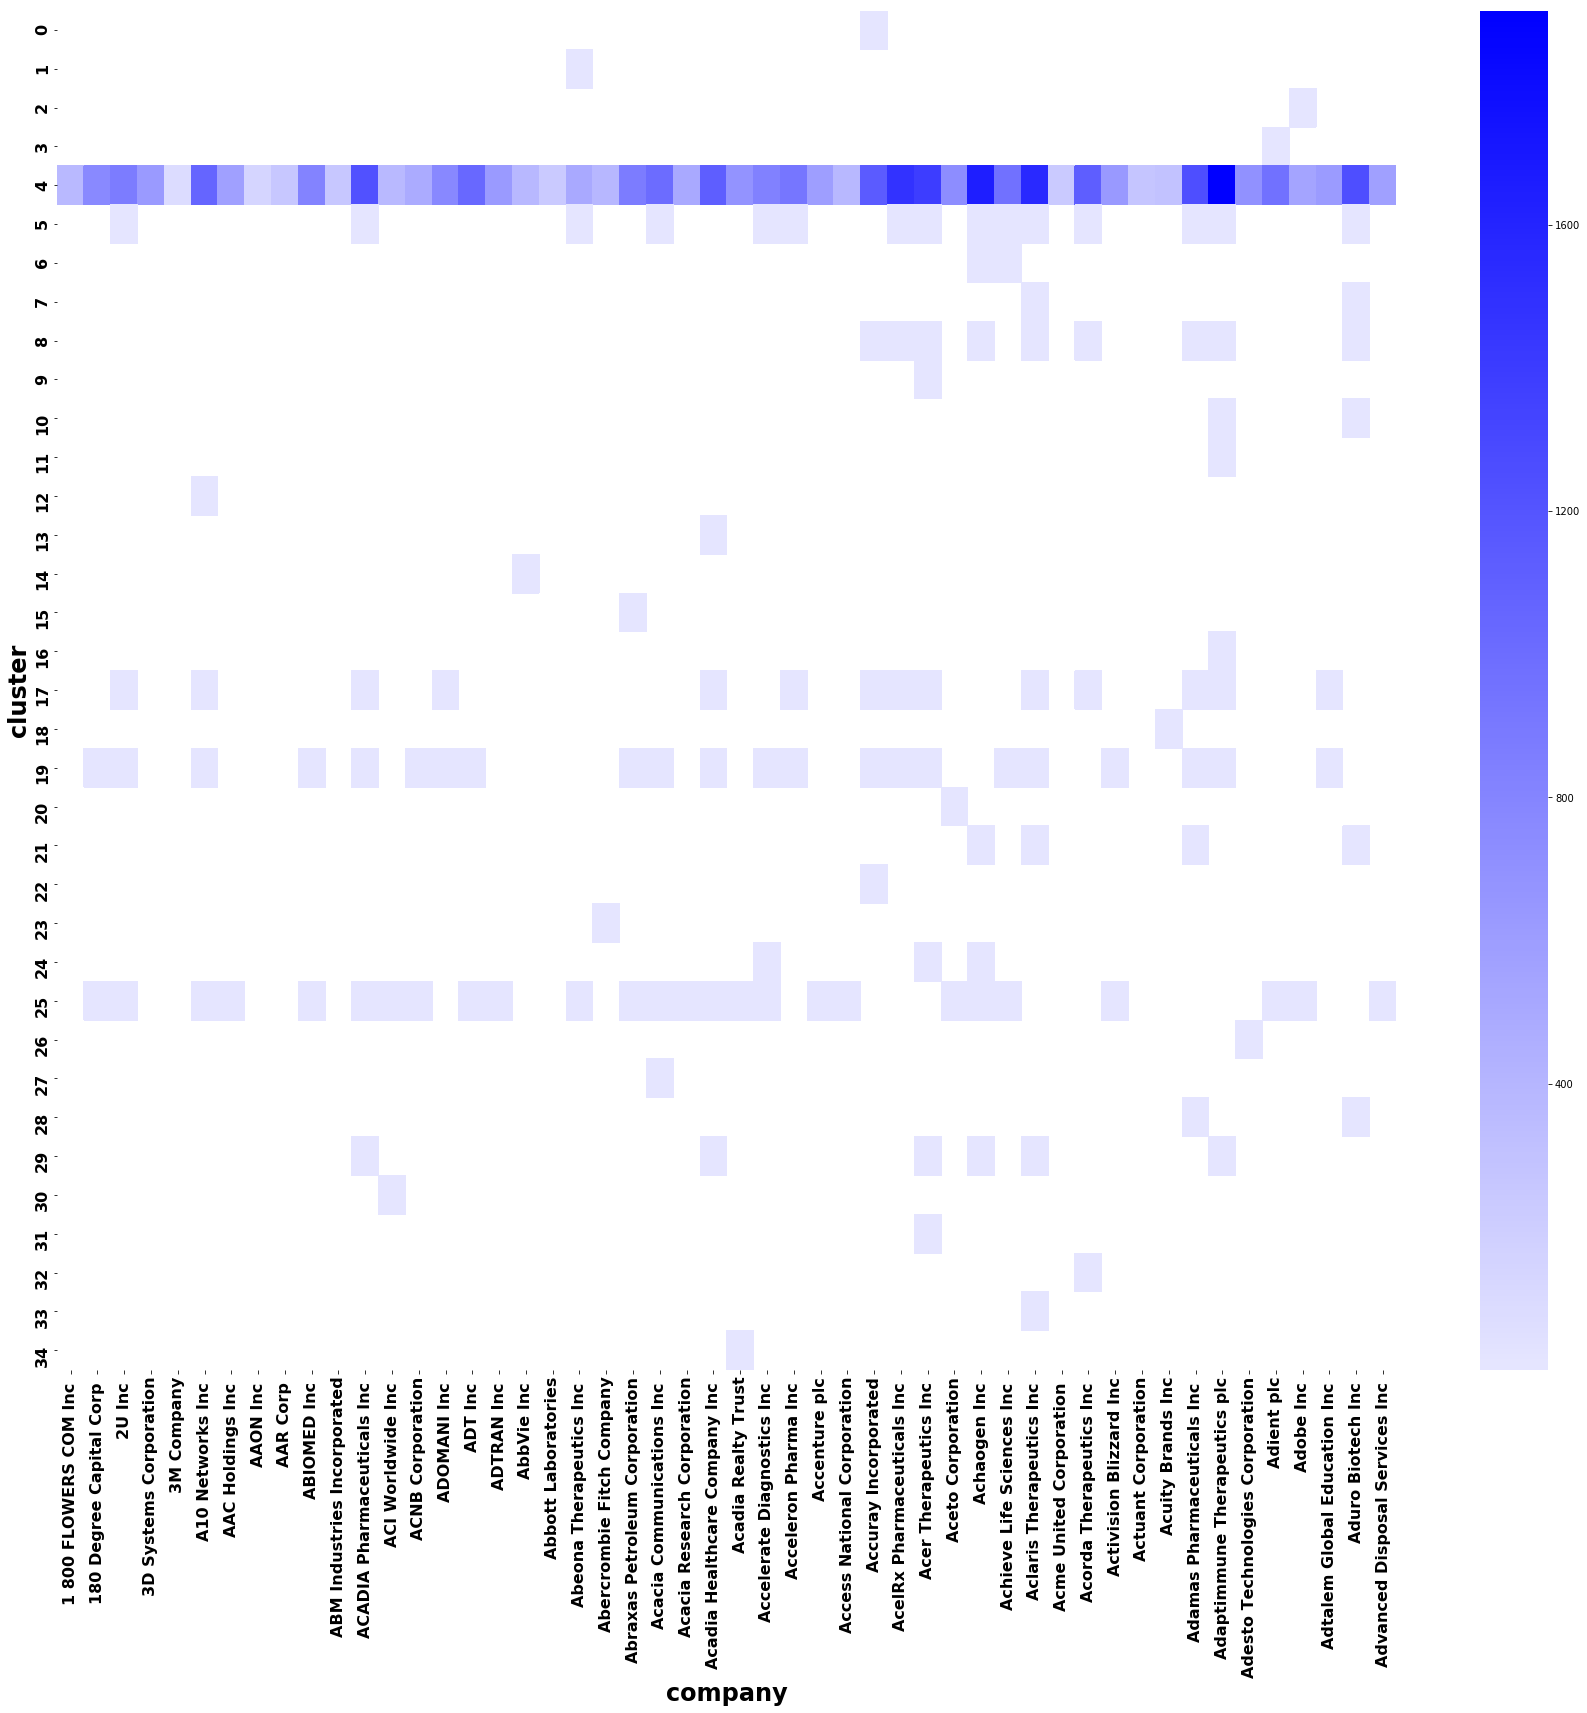

In [28]:
clusters = all_doc_df.groupby(['cluster', 'company']).size()
fig2, ax2 = plt.subplots(figsize = (30, 25))
cmap = sns.light_palette('blue', as_cmap=True)

sns.heatmap(clusters.unstack(level = 'company'), ax = ax2, cmap = cmap)

ax2.set_xlabel('company', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

In [29]:
def get_wordDict(wordSet):
    wordDict = dict.fromkeys(wordSet, 0) 
    for word in wordSet:
        wordDict[word]+=1

    return wordDict

In [30]:


def computeTF(document_text, stopWordsSet):
    wordset = split_document(document_text, stopWordsSet)
    word_dict = get_wordDict(wordset)
    tfDict = {}
    word_count = len(wordset)
    for word, count in word_dict.items():
        tfDict[word] = count/float(word_count)
    return tfDict

In [31]:
doclist[0]

'[1] "Item 1A.    Risk Factors.. Investing in our common stock involves significant risks relating to our business and investment objectives. You should carefully consider the risks and uncertainties described below before you purchase any shares of our common stock. These risks and uncertainties are not the only ones we face. Unknown additional risks and uncertainties, or ones that we currently consider immaterial, may also impact our business. If any of these risks or uncertainties materialize, our business, financial condition or results of operations could be materially adversely affected. In this event, the trading price of our common stock could decline, and you could lose all or part of your investment.. Risks related to our proposed change from a BDC to a registered closed-end fund.. If shareholders approve the proposal to authorize the Board of Directors to withdraw the Company\'s election to be regulated as a BDC, the withdrawal will become effective upon receipt by the SEC o

In [32]:
term_freqs = []
for i  in range(len(doclist)):
#     print(i)
    term_frequency = computeTF(doclist[i], stopWordsSet)
    term_freqs.append(term_frequency)

In [33]:
term_freqs[0]

{'[1] "item 1a': 0.0012970168612191958,
 '    risk factors': 0.0012970168612191958,
 '': 0.2204928664072633,
 ' investing in our common stock involves significant risks relating to our business and investment objectives': 0.0012970168612191958,
 ' you should carefully consider the risks and uncertainties described below before you purchase any shares of our common stock': 0.0012970168612191958,
 ' these risks and uncertainties are not the only ones we face': 0.0012970168612191958,
 ' unknown additional risks and uncertainties, or ones that we currently consider immaterial, may also impact our business': 0.0012970168612191958,
 ' if any of these risks or uncertainties materialize, our business, financial condition or results of operations could be materially adversely affected': 0.0012970168612191958,
 ' in this event, the trading price of our common stock could decline, and you could lose all or part of your investment': 0.0012970168612191958,
 ' risks related to our proposed change fr

In [34]:
def computeIDF(docList):
    idfDict = {}
    N = len(docList)
    big_wordset = []
    for doc in docList:
        big_wordset += split_document(doc, stopWordsSet)
    big_wordDict = get_wordDict(big_wordset)
        
    idfDict = dict.fromkeys(big_wordDict.keys(), 0)
  
    for word, val in big_wordDict.items():
        if val > 0:
            idfDict[word] += 1

    for word, val in idfDict.items():
        idfDict[word] = math.log10(N / float(val))
        
    return idfDict

In [35]:
idfs = computeIDF(doclist)
idfs

{'[1] "item 1a': 1.6989700043360187,
 '    risk factors': 1.6989700043360187,
 '': 1.6989700043360187,
 ' investing in our common stock involves significant risks relating to our business and investment objectives': 1.6989700043360187,
 ' you should carefully consider the risks and uncertainties described below before you purchase any shares of our common stock': 1.6989700043360187,
 ' these risks and uncertainties are not the only ones we face': 1.6989700043360187,
 ' unknown additional risks and uncertainties, or ones that we currently consider immaterial, may also impact our business': 1.6989700043360187,
 ' if any of these risks or uncertainties materialize, our business, financial condition or results of operations could be materially adversely affected': 1.6989700043360187,
 ' in this event, the trading price of our common stock could decline, and you could lose all or part of your investment': 1.6989700043360187,
 ' risks related to our proposed change from a bdc to a registered

In [36]:
def computeTFIDF(term_frequency, idfs):
    tfidf = {}
    for word, val in term_frequency.items():
        tfidf[word] = val*idfs[word]
    return tfidf

In [37]:
tfidfBow = computeTFIDF(term_frequency, idfs)


In [38]:
tfidfBow


{'[1] "item 1a': 0.002954730442323511,
 '     risk factors': 0.002954730442323511,
 ' our ability to achieve future profitability will depend on us executing on our strategy and controlling costs': 0.002954730442323511,
 ' future results may be impacted by expiration of nols': 0.002954730442323511,
 '': 0.3870696879443799,
 ' although our business generates significant adjusted ebitda and free cash flow, we have significant non-cash expenses, such as depreciation, depletion and amortization, that are common in waste management businesses and can be increased substantially by acquisitions': 0.002954730442323511,
 ' these non-cash expense items have had, and may continue to have, a significant impact on our reported pre-tax and after-tax profit or loss': 0.002954730442323511,
 '  in addition, our ability to continue to achieve profitability will depend on our successfully executing on our strategy of developing vertically integrated geographic operations while maintaining a consistent op

In [39]:
# from https://stackoverflow.com/questions/4743035/obtaining-the-least-common-element-in-array
def least_common_values(array, to_find=None):
    counter = collections.Counter(array)
    if to_find is None:
        return sorted(counter.items(), key=itemgetter(1), reverse=False)
    return heapq.nsmallest(to_find, counter.items(), key=itemgetter(1))
least_common_values(tfidfBow, 20)

[('[1] "item 1a', 0.002954730442323511),
 ('     risk factors', 0.002954730442323511),
 (' our ability to achieve future profitability will depend on us executing on our strategy and controlling costs',
  0.002954730442323511),
 (' future results may be impacted by expiration of nols',
  0.002954730442323511),
 (' although our business generates significant adjusted ebitda and free cash flow, we have significant non-cash expenses, such as depreciation, depletion and amortization, that are common in waste management businesses and can be increased substantially by acquisitions',
  0.002954730442323511),
 (' these non-cash expense items have had, and may continue to have, a significant impact on our reported pre-tax and after-tax profit or loss',
  0.002954730442323511),
 ('  in addition, our ability to continue to achieve profitability will depend on our successfully executing on our strategy of developing vertically integrated geographic operations while maintaining a consistent operat

In [40]:
collections.Counter(tfidfBow).most_common(20)


[('', 0.3870696879443799),
 (' table of contents', 0.03545676530788213),
 ('s', 0.0265925739809116),
 (' and', 0.008864191326970533),
 (' similar risks may affect contracts that we are awarded to operate municipally owned assets, such as landfills',
  0.005909460884647022),
 (' additionally, the loss of municipal contracts through competitive bidding, early termination or governmental action could cause long lived tangible and intangible assets to be impaired and require a charge against earnings',
  0.005909460884647022),
 (" see ''management's discussion and analysis of financial condition and results of operations - critical accounting policies and estimates - landfill accounting - amortization of landfill assets",
  0.005909460884647022),
 ("''", 0.005909460884647022),
 ('c', 0.005909460884647022),
 ('[1] "item 1a', 0.002954730442323511),
 ('     risk factors', 0.002954730442323511),
 (' our ability to achieve future profitability will depend on us executing on our strategy and con

In [41]:
collections.Counter(term_frequency).most_common(20)



[('', 0.22782608695652173),
 (' table of contents', 0.020869565217391306),
 ('s', 0.01565217391304348),
 (' and', 0.0052173913043478265),
 (' similar risks may affect contracts that we are awarded to operate municipally owned assets, such as landfills',
  0.0034782608695652175),
 (' additionally, the loss of municipal contracts through competitive bidding, early termination or governmental action could cause long lived tangible and intangible assets to be impaired and require a charge against earnings',
  0.0034782608695652175),
 (" see ''management's discussion and analysis of financial condition and results of operations - critical accounting policies and estimates - landfill accounting - amortization of landfill assets",
  0.0034782608695652175),
 ("''", 0.0034782608695652175),
 ('c', 0.0034782608695652175),
 ('[1] "item 1a', 0.0017391304347826088),
 ('     risk factors', 0.0017391304347826088),
 (' our ability to achieve future profitability will depend on us executing on our strat

In [42]:
# Latent Dirichlet Allocation
# Ref http://brandonrose.org/clustering
# LDA is a probabilistic topic model that assumes documents
# are a mixture of topics and that each word in the document is attributable to the document's topics.
from nltk.stem.snowball import SnowballStemmer
import re
stemmer = SnowballStemmer("english")
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

input_texts = doclist

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns
from gensim import corpora, models, similarities 

#remove proper names0
%time preprocess = [strip_proppers(doc) for doc in input_texts]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]
# print(texts)
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)
# print(dictionary)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.1)  
# THIS FILTERS EVERYTHING OUT
print(dictionary)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]
# print(corpus)
%time lda = models.LdaModel(corpus, num_topics=5, id2word=dictionary, update_every=5, chunksize=10000, passes=100)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xanen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Wall time: 6.89 s
Wall time: 12.3 s
Wall time: 1.03 s
Dictionary(4449 unique tokens: ['30-day', 'absent', 'adverse..', 'adviser..', 'agnost']...)
Wall time: 6.19 s


In [43]:
topics_matrix = lda.show_topics(formatted=False, num_words=15)
topics_matrix = np.array(topics_matrix)

topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

['student', 'zero-emiss', 'game', 'drivetrain', 'hybrid', 'graduat', 'accredit', 'school', 'batteri', 'entertain', 'colleg', 'aid', 'tuition', 'faculti', 'k']

['\\t\\t\\t', '\\t\\t', 'plazomicin', '\\t\\t\\tthe', 'inhibitor', 'assay', 'foundri', 'automot', 'semiconductor', 'wart', 'mortgag', 'memori', '\\t\\t\\tour', 'bacteri', 'peroxid']

['\\t\\t\\t', 'luspatercept', 'sotatercept', 'landfil', 'pain', 'resubmit', 'inhal', 'resubmiss', 'opioid', 'dyskinesia', 'acut', 'sufentanil', 'levodopa', 'moderate-to-sever', 'biosimilar']

['alarm', 'dealer', 'subscrib', 'peptid', 'rent', 'timescal', 'vector', 'pivot', 'biosimilar', 'truste', 'foundri', 'fatal', 'redeem', 'email', 'reagent']

['cytisin', 'end-custom', 'drill', 'pimavanserin', 'merchandis', 'fractur', 'hallucin', 'delus', 'radiat', 'aircraft', 'hydraul', 'swap', 'subscript', 'psychiatrist', 'undevelop']



In [44]:
# https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing
lsi = models.lsimodel.LsiModel(corpus, num_topics=5, id2word=dictionary, chunksize=1000)
topics_matrix = lsi.show_topics(formatted=False, num_words=15)
topics_matrix = np.array(topics_matrix)
topic_words = topics_matrix[:,1]
for i in topic_words:
    print([str(word[0]) for word in i])
    print()

['\\t\\t\\t', '\\t\\t', '\\t\\t\\tthe', 'inhibitor', 'pain', '\\t\\t\\tour', 'wart', 'resubmiss', 'opioid', 'resubmit', 'acut', 'sufentanil', 'peroxid', '\\t\\t\\twe', 'foundri']

['cytisin', 'cytisine..', 'counterfeit', 'smoke', 'anagyroid', 'tree', 'uncov', 'student', 'sunshin', 'toxicolog', 'authent', 'naturally-occur', 'inhal', 'pivot', 'display']

['student', 'graduat', 'accredit', 'school', 'colleg', 'faculti', 'tuition', 'aid', 'postsecondari', 'accreditor', 'admiss', 'nonprofit', 'misrepresent', 'degree-gr', 'reauthor']

['zero-emiss', 'drivetrain', 'hybrid', 'batteri', 'subsidi', 'buse', 'truck', 'fleet', 'lithium-ion', 'lock-up', 'petroleum-bas', 'motor', 'dealer', 'kit', 'pack']

['plazomicin', 'assay', 'bacteri', 'redeem', 'protest', 'gram-neg', 'cold-chain', 'plazomicin..', '21st', 'aminoglycosid', 'antibiot', 'bacteria', 'vitro', 'pathogen', 'government-fund']



In [45]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(X[0])
print()
print(dist)


[[0.]]


In [46]:
# SUMMARIZATION OF CORPORATE RISK FACTOR DISCLOSURE THROUGH TOPIC MODELING by Bao, Datta

# Topic 0: investment, property, distribution, interest, agreement Shareholder’s interest risk 
# Topic 1: regulation, change, law, financial, operation, tax, accounting *Regulation changes(accounting)
# Topic 2: gas, price, oil, natural, operation, production Input prices risks 
# Topic 3: stock, price, share, market, future, dividend, security, stakeholder ** Stakeholder’s profit
# Topic 4: cost, regulation, environmental, law, operation, liability *Regulation changes(environment) 
# Topic 5: control, financial, internal, loss, reporting, history Financial condition risks 
# Topic 6: financial, litigation, operation, condition, action, legal, liability, regulatory, claim, lawsuit *Potential/Ongoing Lawsuits
# Topic 7: competitive, industry, competition, highly, market Competition risks 
# Topic 8: cost, operation, labor, operating, employee, increase, acquisition **Labor cost 
# Topic 9: product, candidate, development, approval, clinical, regulatory New product introduction risks 
# Topic 10: tax, income, asset, net, goodwill, loss, distribution, impairment, intangible **Accounting,  +Restructuring risks 
# Topic 11: interest, director, officer, trust, combination, share, conflict **Management
# Topic 12: product, liability, claim, market, insurance, sale, revenue Potential defects in products 
# Topic 13: loan, real, estate, investment, property, market, loss, portfolio **Investment 
# Topic 14: personnel, key, retain, attract, management, employee Human resource risks 
# Topic 15: stock, price, operating, stockholder, fluctuate, interest, volatile Volatile stock price risks 
# Topic 16: acquisition, growth, future, operation, additional, capital, strategy Merger & Acquisition risks 
# Topic 17: condition, economic, financial, market, industry, change, affected, downturn, demand Macroeconomic risks, +Industry is cyclical 
# Topic 18: system, service, information, failure, product, operation, software, network, breach, interruption Disruption of operations, +Infrastructure risks 
# Topic 19: cost, contract, operation, plan, increase, pension, delay **Postpone 
# Topic 20: customer, product, revenue, sale, supplier, relationship, key, portion, contract, manufacturing, rely Rely on few large customers, +Suppliers risks +Downstream risks 
# Topic 21: property, intellectual, protect, proprietary, technology, patent, protection, harm, license Intellectual property risks, +Licensing related risks 
# Topic 22: product, market, service, change, sale, demand, successfully, technology, competition Volatile demand and results, + Competition risks 
# Topic 23: provision, law, control, change, stock, prevent, stockholder, Delaware, charter, delay, bylaw *Potential/Ongoing Lawsuits 
# Topic 24: regulation, government, change, revenue, contract, law, service *Regulation changes 
# Topic 25: capital, credit, financial, market, cost, operation, rating, access, liquidity, downgrade **Credit risks 
# Topic 26: debt, indebtedness, cash, obligation, financial, credit, covenant Funding risks 
# Topic 27: operation, international, foreign, currency, rate, fluctuation International risks 
# Topic 28: loss, insurance, financial, loan, reserve, operation, cover **Insurance 
# Topic 29: operation, natural, facility, disaster, event, terrorist, weather Catastrophes